* [Fonctions :](#fonction)
* [Mission 1 :](#mission1)
    * [Resumé les données](#customers)
* [Mission 2 :](#mission2)
* [Mission 3 :](#mission3)
* [Mission 4 :](#mission3)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import scipy.stats as st 
from collections import Counter
import statsmodels.formula.api as smf
from sklearn import preprocessing
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#pd.options.mode.chained_assignment = None

In [2]:
data_income = pd.read_csv('data-projet7.csv')
pop = pd.read_csv('population.csv', error_bad_lines=False)
gini = pd.read_csv('gini.csv', error_bad_lines=False)
gdim = pd.read_csv('GDIMMay2018.csv')

# Fonctions : <a class="anchor" id="fonction"></a>

In [3]:


def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='8', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=True)
            plt.savefig("High resoltion.png",dpi=300)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)
    plt.savefig("Eboulis valeur porpres.png",dpi=300)
    

def plot_dendrogram(Z, names):
    plt.figure(figsize=(10,25))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    plt.show()

In [4]:
def generate_incomes(n, pj):
    # On génère les revenus des parents (exprimés en logs) selon une loi normale.
    # La moyenne et variance n'ont aucune incidence sur le résultat final (ie. sur le caclul de la classe de revenu)
    ln_y_parent = st.norm(0,1).rvs(size=n)
    # Génération d'une réalisation du terme d'erreur epsilon
    residues = st.norm(0,1).rvs(size=n)
    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)
    
def quantiles(l, nb_quantiles):
    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
    return pd.Series([q_dict[e] for e in l])

def compute_quantiles(y_child, y_parents, nb_quantiles):
    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
    return sample

def distribution(counts, nb_quantiles):
    distrib = []
    total = counts["counts"].sum()
    
    if total == 0 :
        return [0] * nb_quantiles
    
    for q_p in range(1, nb_quantiles+1):
        subset = counts[counts.c_i_parent == q_p]
        if len(subset):
            nb = subset["counts"].values[0]
            distrib += [nb / total]
        else:
            distrib += [0]
    return distrib   

def conditional_distributions(sample, nb_quantiles):
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    
    mat = []
    for child_quantile in np.arange(nb_quantiles)+1:
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return np.array(mat) 

def plot_conditional_distributions(p, cd, nb_quantiles):
    plt.figure()
    
    # La ligne suivante sert à afficher un graphique en "stack bars", sur ce modèle : https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
    cumul = np.array([0] * nb_quantiles)
    
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)

    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title("p=" + str(p))
    plt.legend()
    plt.xlabel("quantile parents")
    plt.ylabel("probabilité du quantile enfant")
    plt.show()
    
def proba_cond(c_i_parent, c_i_child, mat):
    return mat[c_i_child, c_i_parent]

#pj = 0.9                 # coefficient d'élasticité du pays j
#nb_quantiles = 100       # nombre de quantiles (nombre de classes de revenu)
#n  = 1000*nb_quantiles   # taille de l'échantillon

#y_child, y_parents = generate_incomes(n, pj)
#sample = compute_quantiles(y_child, y_parents, nb_quantiles)
#cd = conditional_distributions(sample, nb_quantiles)
#plot_conditional_distributions(pj, cd, nb_quantiles) # Cette instruction prendra du temps si nb_quantiles > 10
#print(cd)

#c_i_child = 5 
#c_i_parent = 8
#p = proba_cond(c_i_parent, c_i_child, cd)
#print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child, pj, p))

# Mission 1 : <a class="anchor" id="mission1"></a>

##### Résumez les données utilisées :
#####     Année(s) des données utilisées
#####    Nombre de pays présent
#####    Population couverte par l'analyse (en termes de pourcentage de la population mondiale)

In [5]:
data_income

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,"728,89795",7297
1,ALB,2008,2,100,"916,66235",7297
2,ALB,2008,3,100,"1010,916",7297
3,ALB,2008,4,100,"1086,9078",7297
4,ALB,2008,5,100,"1132,6997",7297
...,...,...,...,...,...,...
11594,COD,2008,96,100,"810,6233","303,19305"
11595,COD,2008,97,100,"911,7834","303,19305"
11596,COD,2008,98,100,"1057,8074","303,19305"
11597,COD,2008,99,100,"1286,6029","303,19305"


In [6]:
data_income['year_survey'].unique()

array([2008, 2009, 2010, 2007, 2006, 2011, 2004])

##### Les années des données utilisé sont 2008, 2009, 2010, 2007, 2006, 2011, 2004

In [7]:
country = len(data_income['country'].unique())
country

116

##### Il y'a 116 pays étudié

In [8]:
#Nombre de valeurs manquantes
data_income.isnull().sum()

country           0
year_survey       0
quantile          0
nb_quantiles      0
income            0
gdpppp          200
dtype: int64

In [9]:
# pays dont la valeur pour le gdpppp manque 
drop_index = data_income.loc[data_income['gdpppp'].isnull(),:].index
drop_df = data_income.iloc[drop_index]
drop_df

,country,year_survey,quantile,nb_quantiles,income,gdpppp
5800,XKX,2008,1,100,"437,8937",NaN
5801,XKX,2008,2,100,"508,17133",NaN
5802,XKX,2008,3,100,"591,8282",NaN
5803,XKX,2008,4,100,668,NaN
5804,XKX,2008,5,100,"730,4022",NaN
...,...,...,...,...,...,...
11294,PSE,2009,96,100,"2763,8848",NaN
11295,PSE,2009,97,100,"3077,8333",NaN
11296,PSE,2009,98,100,"3449,2224",NaN
11297,PSE,2009,99,100,"4165,997",NaN


##### J'ai décidé d'écarter ces pays de mon étude car ce sont des pays qui n'offrent pas une stabilité suffisante pour pouvoir pérenniser la relation avec les clients

In [10]:
# Suppréssion des valeurs manquantes 
drop_index = data_income.loc[data_income['gdpppp'].isnull(),:].index
data_income =data_income.drop(index=drop_index)
data_income.isnull().sum()

country         0
year_survey     0
quantile        0
nb_quantiles    0
income          0
gdpppp          0
dtype: int64

In [11]:
# changement du type de la colonne pour qu'elle devienne de type "string"
# pour pouvoir changer les virgules en points
data_income['gdpppp'] = data_income['gdpppp'].astype(str)
data_income['gdpppp']

# Changement des virgules en points 
data_income['income'] = data_income['income'].apply(lambda x: str(x.replace(',','.')))
data_income['gdpppp'] = data_income['gdpppp'].apply(lambda x: str(x.replace(',','.')))

# Changement du type de la colonne en numérique 
data_income['income'] = pd.to_numeric(data_income['income'])

In [12]:
# recherche de la ligne manquante 
income_country = data_income.groupby('country').count()
income_country = income_country[income_country['quantile'] != 100]
income_country

,year_survey,quantile,nb_quantiles,income,gdpppp
country,,,,,
LTU,99,99,99,99,99


###### On constate que le pays auquel il manque un quantile est la Lituanie. 


In [13]:
#Je crée une liste qui va de 1 à 100
one_to_100 = list(range(1,101))

#Je récupère les données relatif à la Lituanie
df_lit = data_income[data_income['country'] == "LTU"]

#Je recherche quel nombre de ma liste "one_to_100" n'est pas dans les quantiles de la Lituanie
for i in one_to_100:
    if (i not in list(df_lit['quantile'])) == True:
        print(i)

41


##### Le quantile manquant est le quantile 41

In [14]:
#Je calcule la moyenne entre le quantile 40 et 42 
lit_quant = data_income.loc[(data_income['country'] == 'LTU') & (data_income['quantile'] == 42) |
        (data_income['country'] == 'LTU') & (data_income['quantile'] == 40),'income'].mean()
lit_quant


4882.14065

In [15]:
# Création de la ligne manquante 
lit_df = pd.DataFrame({'country' :  ['LTU'],
                        'year_survey' : [2008],
                        'quantile' : [41],
                        'nb_quantiles' : [100],
                        'income' : [lit_quant],
                        'gdpppp'  :  [17571.0]})
lit_df

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,LTU,2008,41,100,4882.14065,17571.0


In [16]:
#Je rajoute la ligne au dataframe 
data = pd.concat([data_income, lit_df], ignore_index=True, sort=True)
data.sort_values(by=['country', 'quantile', 'year_survey'], inplace=True)

In [17]:
#information par années 
year_data = data.groupby(by=['year_survey']).nunique().reset_index()
year_data

,year_survey,country,gdpppp,income,nb_quantiles,quantile
0,2004,1,1,100,1,100
1,2006,5,5,500,1,100
2,2007,15,15,1500,1,100
3,2008,75,76,7499,1,100
4,2009,11,11,1100,1,100
5,2010,6,6,600,1,100
6,2011,1,1,100,1,100


Text(0.5, 1.0, 'Nombre de pays par année')

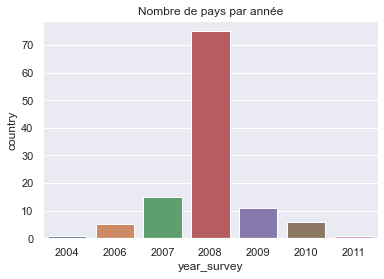

In [105]:
sns.barplot(x='year_survey', y='country', data=year_data)
plt.title('Nombre de pays par année')

##### On constate que l'année 2008 est l'année contenant le plus d'information avec 76 pays 

In [19]:
pop = pop[["Country Name","Country Code", "2008"]]
pop

,Country Name,Country Code,2008
0,Aruba,ABW,101362.0
1,Africa Eastern and Southern,AFE,491173160.0
2,Afghanistan,AFG,27722281.0
3,Africa Western and Central,AFW,331772330.0
4,Angola,AGO,21695636.0
...,...,...,...
261,Kosovo,XKX,1747383.0
262,"Yemen, Rep.",YEM,21892149.0
263,South Africa,ZAF,49779472.0
264,Zambia,ZMB,12848531.0


In [20]:
# Population mondiale en 2008
pop_wld = pop[pop['Country Code'] == "WLD"]
pop_wld = pop_wld['2008']
pop_wld 

259    6.757021e+09
Name: 2008, dtype: float64

In [21]:
data = data.rename(columns={"country": "Country Code"})
data_2008 = data[data['year_survey'] == 2008]
data_by_country = data_2008.groupby(by='Country Code').sum().reset_index()
data_by_country = data_by_country.merge(pop , on='Country Code', how='left')
data_by_country

,Country Code,income,nb_quantiles,quantile,year_survey,Country Name,2008
0,ALB,2.994830e+05,10000,5050,200800,Albania,2947314.0
1,ARG,5.847885e+05,10000,5050,200800,Argentina,40080159.0
2,ARM,1.628383e+05,10000,5050,200800,Armenia,2907615.0
3,AUT,1.663760e+06,10000,5050,200800,Austria,8321496.0
4,AZE,2.357429e+05,10000,5050,200800,Azerbaijan,8763400.0
...,...,...,...,...,...,...,...
70,UKR,3.349388e+05,10000,5050,200800,Ukraine,46258189.0
71,URY,5.290785e+05,10000,5050,200800,Uruguay,3340221.0
72,USA,2.550358e+06,10000,5050,200800,United States,304093966.0
73,YEM,1.042636e+05,10000,5050,200800,"Yemen, Rep.",21892149.0


In [22]:
#Population des pays de notre étude
pop_study = data_by_country['2008'].sum()
pop_study


2301970844.0

In [23]:
ratio = pop_study / pop_wld
ratio

259    0.340678
Name: 2008, dtype: float64

##### On étudie 34 % de la population mondiale

# mission 2 : <a class="anchor" id="mission2"></a>

#### Montrez la diversité des pays en termes de distribution de revenus à l'aide d'un graphique. Celui-ci représentera le revenu moyen (axe des ordonnées, sur une échelle logarithmique) de chacune des classes de revenus (axe des abscisses) pour 5 à 10 pays que vous aurez choisis pour montrer la diversité des cas.

#### Choix des pays grâce à un algorithme de classification

In [24]:
data = data_2008[["Country Code", "gdpppp", "income","quantile"]]
data

,Country Code,gdpppp,income,quantile
0,ALB,7297,728.89795,1
1,ALB,7297,916.66235,2
2,ALB,7297,1010.91600,3
3,ALB,7297,1086.90780,4
4,ALB,7297,1132.69970,5
...,...,...,...,...
11294,ZAF,9602,24553.56800,96
11295,ZAF,9602,28858.03100,97
11296,ZAF,9602,35750.29000,98
11297,ZAF,9602,46297.31600,99


In [25]:
#Liste des pays
country = data['Country Code'].drop_duplicates().values

#Création colonne vide
data['Gini'] = 0

#Calcul de l'indice de Gini pour chaque pays
for i in country:
    income = data.loc[data['Country Code'] == i].income.values
    lorenz = np.cumsum(np.sort(income)) / income.sum()
    lorenz = np.append([0], lorenz)
    data.loc[data['Country Code'] == i, 'Gini'] = 2 * (0.5 - (lorenz[:-1].sum() / len(lorenz)))

<ipython-input-25-5ff325879e22>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Gini'] = 0
/Users/emmanuelmoudoute-bell/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [26]:
data

,Country Code,gdpppp,income,quantile,Gini
0,ALB,7297,728.89795,1,0.321410
1,ALB,7297,916.66235,2,0.321410
2,ALB,7297,1010.91600,3,0.321410
3,ALB,7297,1086.90780,4,0.321410
4,ALB,7297,1132.69970,5,0.321410
...,...,...,...,...,...
11294,ZAF,9602,24553.56800,96,0.682949
11295,ZAF,9602,28858.03100,97,0.682949
11296,ZAF,9602,35750.29000,98,0.682949
11297,ZAF,9602,46297.31600,99,0.682949


In [27]:
data = pd.merge(data, pop, left_on = 'Country Code', right_on='Country Code')


In [28]:
data

,Country Code,gdpppp,income,quantile,Gini,Country Name,2008
0,ALB,7297,728.89795,1,0.321410,Albania,2947314.0
1,ALB,7297,916.66235,2,0.321410,Albania,2947314.0
2,ALB,7297,1010.91600,3,0.321410,Albania,2947314.0
3,ALB,7297,1086.90780,4,0.321410,Albania,2947314.0
4,ALB,7297,1132.69970,5,0.321410,Albania,2947314.0
...,...,...,...,...,...,...,...
7395,ZAF,9602,24553.56800,96,0.682949,South Africa,49779472.0
7396,ZAF,9602,28858.03100,97,0.682949,South Africa,49779472.0
7397,ZAF,9602,35750.29000,98,0.682949,South Africa,49779472.0
7398,ZAF,9602,46297.31600,99,0.682949,South Africa,49779472.0


In [29]:
# changement du type de la colonne "gdpppp"
data['gdpppp'] = data['gdpppp'].astype(float)
data['gdpppp'] 


0       7297.0
1       7297.0
2       7297.0
3       7297.0
4       7297.0
         ...  
7395    9602.0
7396    9602.0
7397    9602.0
7398    9602.0
7399    9602.0
Name: gdpppp, Length: 7400, dtype: float64

In [30]:
data.rename(columns={'2008': 'Population'}, inplace=True)


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7400 entries, 0 to 7399
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Code  7400 non-null   object 
 1   gdpppp        7400 non-null   float64
 2   income        7400 non-null   float64
 3   quantile      7400 non-null   int64  
 4   Gini          7400 non-null   float64
 5   Country Name  7400 non-null   object 
 6   Population    7400 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 462.5+ KB


In [32]:
data_clustering = data[["gdpppp", "income", "Gini", 'Country Code']].groupby(by=['Country Code']).mean()

In [33]:
data_clustering 

,gdpppp,income,Gini
Country Code,,,
ALB,7297.0,2994.829902,0.321410
ARG,13220.0,5847.884654,0.465249
ARM,5611.0,1628.382785,0.280305
AUT,36193.0,16637.600204,0.295326
AZE,8101.0,2357.429023,0.329031
...,...,...,...
UKR,6721.0,3349.388306,0.272415
URY,11682.0,5290.784920,0.475060
USA,43261.0,25503.581661,0.447326


In [34]:
kmeans = cluster.KMeans(n_clusters=6)
kmeans.fit(data_clustering)

#index triés des groupes
idk = np.argsort(kmeans.labels_)

#affichage des observations et leurs groupes
group_df = pd.DataFrame({"clusters":kmeans.labels_[idk]},data_clustering.index[idk])


#distances aux centres de classes des observations
print(kmeans.transform(data_clustering))

[[4.94090652e+03 4.29303509e+06 3.32517996e+04 4.29948888e+03
  6.94797723e+04 1.96556377e+04]
 [1.64119095e+03 4.28711364e+06 2.66955805e+04 1.08337396e+04
  6.29605676e+04 1.30848777e+04]
 [7.06017692e+03 4.29472103e+06 3.53940916e+04 2.46266356e+03
  7.15182471e+04 2.17847575e+04]
 [2.70150029e+04 4.26416379e+06 2.74691020e+03 3.62008864e+04
  3.79174908e+04 1.23297559e+04]
 [4.55931537e+03 4.29223101e+06 3.28801656e+04 4.97156654e+03
  6.89272543e+04 1.92556012e+04]
 [2.39472596e+04 4.26679058e+06 5.11131669e+03 3.31417860e+04
  4.08578579e+04 9.29791812e+03]
 [1.88551482e+02 4.28833997e+06 2.81909530e+04 9.38079930e+03
  6.43950574e+04 1.45746512e+04]
 [1.10352850e+03 4.28868139e+06 2.90377751e+04 8.74651744e+03
  6.50602428e+04 1.54054932e+04]
 [8.10656721e+03 4.29638210e+06 3.61919074e+04 1.42302371e+03
  7.26522883e+04 2.26742570e+04]
 [2.25707933e+03 4.29077386e+06 3.03937290e+04 7.05855894e+03
  6.67642263e+04 1.68244416e+04]
 [1.18891033e+04 4.29964719e+06 4.01041237e+04 2.6

In [35]:
#moyenne par variable
m = data_clustering.mean()

#TSS
TSS = data_clustering.shape[0]*data_clustering.var(ddof=0) 
print(TSS)

#data.frame conditionnellement aux groupes 
gb = data_clustering.groupby(kmeans.labels_) 

#effectifs conditionnelss
nk = gb.size()
print(nk)
#moyennes conditionnelles
mk = gb.mean()
print("moyennes conditionnelles :")
print(mk)

#pour chaque groupe écart à la moyenne par variable
EMk = (mk-m)**2

#pondéré par les effectifs du groupe
EM = EMk.multiply(nk,axis=0)
#somme des valeurs => BSS
BSS = np.sum(EM,axis=0)

print(BSS)


gdpppp    1.811190e+13
income    3.780498e+09
Gini      7.041868e-01
dtype: float64
0    26
1     1
2    15
3    20
4     1
5    11
dtype: int64
moyennes conditionnelles :
         gdpppp        income      Gini
0  1.171215e+04   4987.908151  0.423554
1  4.300332e+06   2098.730882  0.443783
2  3.622913e+04  19384.272741  0.321570
3  3.363993e+03   1892.689385  0.415837
4  7.312700e+04  25217.562681  0.309837
5  2.422436e+04  11607.397809  0.325266
gdpppp    1.811111e+13
income    3.394184e+09
Gini      1.663697e-01
dtype: float64


In [36]:
#carré du rapport de corrélation
#variance expliquée par l'appartenance aux groupes #pour chaque variable
R2 = BSS/TSS
print("variance expliquée par l'appartenance aux groupes:")
print(R2)

variance expliquée par l'appartenance aux groupes:
gdpppp    0.999956
income    0.897814
Gini      0.236258
dtype: float64


###### On constate que les variables qui ont joué un rôle déterminant dans la constitution des groupes sont le "gdpppp" et les revenus 

In [37]:
print(nk)

0    26
1     1
2    15
3    20
4     1
5    11
dtype: int64


In [38]:
cluster_1 = group_df[group_df['clusters'] == 1]
cluster_4 = group_df[group_df['clusters'] == 4]
print(cluster_1)
print(cluster_4)

              clusters
Country Code          
FJI                  1
              clusters
Country Code          
LUX                  4


###### On remarque que les clusters 1 et 4 sont constitués uniquement de 1 pays chacun, il s'agit des Iles Fidji pour le cluster 1 et du Luxembourg pour le cluster 4.  j'ai décidé de sélectionner ces deux pays pour mon échantillon et de refaire un clustering en les écartant.

In [39]:
# j'écarte le Luxembourg et les iles fidji 
data_clustering_final = data_clustering.reset_index()
data_clustering_final = data_clustering_final[(data_clustering_final['Country Code'] != 'LUX') & (data_clustering_final['Country Code'] != 'FJI') ]
data_clustering_final = data_clustering_final.set_index('Country Code')

In [40]:
# je refais une classification kmean

kmeans = cluster.KMeans(n_clusters=6)
kmeans.fit(data_clustering_final)

#index triés des groupes
idk = np.argsort(kmeans.labels_)

#affichage des observations et leurs groupes
group_df = pd.DataFrame({"clusters":kmeans.labels_[idk]},data_clustering.index[idk])


#distances aux centres de classes des observations
print(kmeans.transform(data_clustering_final))

[[ 4512.93586463 30748.13837967 11886.5905812   2985.44838425
  40220.97492258 21525.25125828]
 [11048.82724236 24180.8990946   5365.2994136   3590.75040006
  33702.88714279 14973.38644187]
 [ 2654.81937199 32881.45449388 13964.85180399  5128.99265606
  42378.1725017  23669.2244021 ]
 [36415.98669506  1952.59922486 20124.67061812 28971.16308651
   9445.19009149 10621.72990856]
 [ 5177.69919703 30353.38706958 11396.12199412  2727.11171822
  39898.53698657 21163.58874326]
 [33356.92057866  2592.00332081 17044.97741375 25905.94396612
  12283.96201184  7684.82986695]
 [ 9595.56899639 25672.15194717  6792.43536382  2134.55932066
  35202.61725702 16470.56736198]
 [ 8958.94206787 26499.27435173  7519.0057702   1754.90823519
  36087.26099491 17336.22582486]
 [ 1607.53679775 33728.78226712 15055.74966041  6150.54464715
  43068.19297903 24480.22449803]
 [ 7273.58678724 27904.29282946  9170.91904061   595.31535747
  37340.12299116 18668.10478283]
 [ 2460.32450415 37628.33300928 18845.40324999  99

In [41]:
#moyenne par variable
m = data_clustering_final.mean()

#TSS
TSS = data_clustering_final.shape[0]*data_clustering_final.var(ddof=0) 
print(TSS)

#data.frame conditionnellement aux groupes 
gb = data_clustering_final.groupby(kmeans.labels_) 

#effectifs conditionnelles
nk = gb.size()
print(nk)
#moyennes conditionnelles
mk = gb.mean()
print("moyennes conditionnelles :")
print(mk)

#pour chaque groupe écart à la moyenne par variable
EMk = (mk-m)**2

#pondéré par les effectifs du groupe
EM = EMk.multiply(nk,axis=0)
#somme des valeurs => BSS
BSS = np.sum(EM,axis=0)

print(BSS)

gdpppp    1.132973e+10
income    3.453976e+09
Gini      6.950807e-01
dtype: float64
0    18
1    11
2    10
3    22
4     4
5     7
dtype: int64
moyennes conditionnelles :
         gdpppp        income      Gini
0   2958.992169   1750.531638  0.429051
1  34425.818182  17468.089309  0.311589
2  18405.900000   7223.704035  0.334892
3   9951.909091   4360.245502  0.431250
4  41188.250000  24653.777179  0.349018
5  26000.142857  13649.823520  0.335391
gdpppp    1.088403e+10
income    3.318028e+09
Gini      1.887814e-01
dtype: float64


In [42]:
# Je crée un dataframe contenant la distance entre les pays et les différents groupes
groupe_distance_df = pd.DataFrame(kmeans.transform(data_clustering_final), data_clustering_final.index)
groupe_distance_df
# Je choisi ensuite le pays le plus proche d'un centre de cluster 
for i in range(6):
    print(groupe_distance_df[i].idxmin(),groupe_distance_df[i].min() )


IRQ 216.73499930573885
DNK 517.7690573629004
EST 602.9836814408133
SRB 591.1523560670973
USA 2240.1920072449907
SVN 1953.416240450863


###### Les pays étant les plus proches de chaque centroïde sont l'Estonie, la Slovénie, Le Danemark, L'Iraq, la Serbie et pour finir les États-Unis 
###### J'ai donc 8 pays dans mon échantillon , l'Estonie, la Slovénie, Le Danemark, L'Iraq, la Serbie, les États-unis, le Luxembourg et les iles Fidji 

In [81]:
data['income'] = data['income'].apply(lambda x: float(x))
data['income_log10'] = data['income'].apply(lambda x: math.log10(x)) 
data

,Country Code,gdpppp,income,quantile,Gini,Country Name,Population,income_log10,revenu_moyen
0,ALB,7297.0,728.89795,1,0.321410,Albania,2947314.0,2.862667,2994.829902
1,ALB,7297.0,916.66235,2,0.321410,Albania,2947314.0,2.962209,2994.829902
2,ALB,7297.0,1010.91600,3,0.321410,Albania,2947314.0,3.004715,2994.829902
3,ALB,7297.0,1086.90780,4,0.321410,Albania,2947314.0,3.036193,2994.829902
4,ALB,7297.0,1132.69970,5,0.321410,Albania,2947314.0,3.054115,2994.829902
...,...,...,...,...,...,...,...,...,...
7395,ZAF,9602.0,24553.56800,96,0.682949,South Africa,49779472.0,4.390115,5617.904880
7396,ZAF,9602.0,28858.03100,97,0.682949,South Africa,49779472.0,4.460267,5617.904880
7397,ZAF,9602.0,35750.29000,98,0.682949,South Africa,49779472.0,4.553280,5617.904880
7398,ZAF,9602.0,46297.31600,99,0.682949,South Africa,49779472.0,4.665556,5617.904880


In [82]:
#Création d'un dataframe ne contenant que les pays de mon échantillon
data_study =  data.set_index('Country Code')
data_study = data_study.loc(axis=0)[ 'IRQ','DNK', 'EST', 'SRB', 'USA','SVN' , 'LUX', 'FJI'].reset_index()
data_study

,Country Code,gdpppp,income,quantile,Gini,Country Name,Population,income_log10,revenu_moyen
0,IRQ,3171.0,185.81454,1,0.376320,Iraq,28385739.0,2.269080,1705.512343
1,IRQ,3171.0,323.82718,2,0.376320,Iraq,28385739.0,2.510313,1705.512343
2,IRQ,3171.0,387.21857,3,0.376320,Iraq,28385739.0,2.587956,1705.512343
3,IRQ,3171.0,434.79593,4,0.376320,Iraq,28385739.0,2.638285,1705.512343
4,IRQ,3171.0,474.28143,5,0.376320,Iraq,28385739.0,2.676036,1705.512343
...,...,...,...,...,...,...,...,...,...
795,FJI,4300332.0,5481.08200,96,0.443783,Fiji,845356.0,3.738866,2098.730882
796,FJI,4300332.0,6205.61400,97,0.443783,Fiji,845356.0,3.792785,2098.730882
797,FJI,4300332.0,7265.12550,98,0.443783,Fiji,845356.0,3.861243,2098.730882
798,FJI,4300332.0,9553.19200,99,0.443783,Fiji,845356.0,3.980149,2098.730882


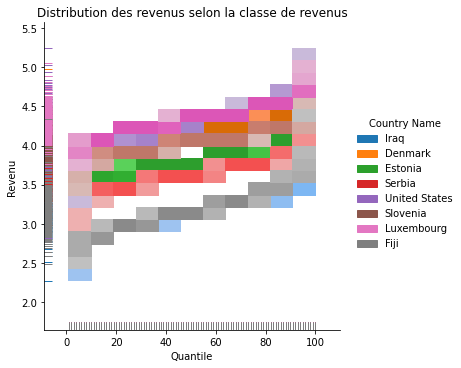

In [83]:
#Affichage de la distribution des revenus en fonction de la classe de revenus
_ = sns.displot(x='quantile', y='income_log10', hue='Country Name', rug=True, height=5, data=data_study)
_ = plt.title('Distribution des revenus selon la classe de revenus')
_ = plt.xlabel('Quantile')
_ = plt.ylabel('Revenu')
_ = plt.show()

##### On remarque que selon les pays la distribution des revenus est plus ou moins élevé.Les pays occidentaux tels que le Luxembourg, les USA ont des bases de revenus qui sont assez élevés. Contrairement à des pays tels que les iles Fidji et L'Irak qui eux ont des revenus faibles comparés aux autres individus de l'échantillon. Entre ces deux groupes de pays on retrouve des pays intermédiaires dont la base de revenu est ni trop basse ni trop élevé.

### Représentez la courbe de Lorenz de chacun des pays choisis.

['IRQ']
Gini :  [0.37632016]
0.7425742574257426


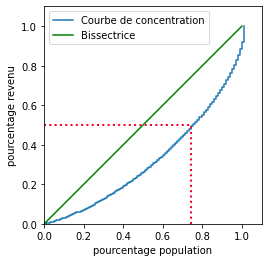

['DNK']
Gini :  [0.27710015]
0.6732673267326733


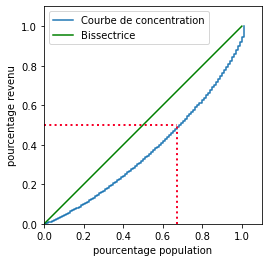

['EST']
Gini :  [0.31752485]
0.7029702970297029


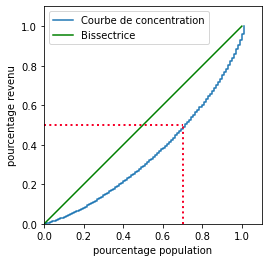

['SRB']
Gini :  [0.29230117]
0.693069306930693


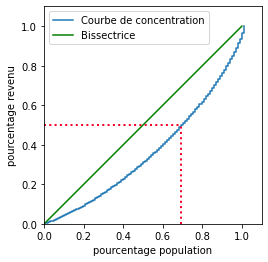

['USA']
Gini :  [0.4473259]
0.7821782178217822


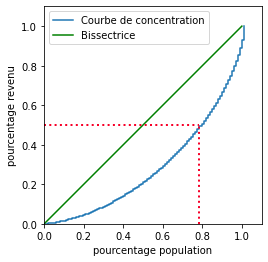

['SVN']
Gini :  [0.24824876]
0.6534653465346535


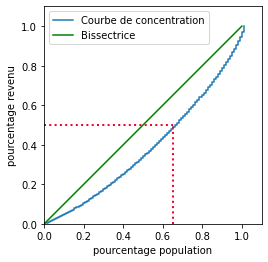

['LUX']
Gini :  [0.30983679]
0.7029702970297029


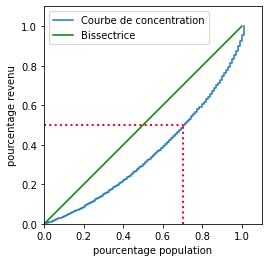

['FJI']
Gini :  [0.44378344]
0.7920792079207921


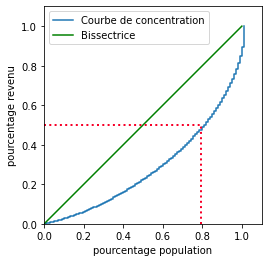

In [84]:
### Courbe de lorenz pour les pays étudiés 
### Cette courbe de Lorenz va nous permettre de savoir comment sont reparti les revenues dans la population de chaque pays 
def lorenz_plot(var) :
    n = len(var)
    lorenz = np.cumsum(np.sort(var)) / var.sum()
    lorenz = np.append([0],lorenz)
    plt.axes().axis('equal')
    xaxis = np.linspace(0-1/n,1+1/n,n+1) 
    plt.plot(xaxis,lorenz,drawstyle='steps-post')
    plt.gca().set_aspect('equal', adjustable = 'box')
    x = [0, 1]
    y = [0, 1]

    plt.plot(x, y, 'green')
    plt.ylabel("pourcentage revenu")
    plt.xlabel('pourcentage population')
    
    medial = len(lorenz[lorenz <= 0.5]) / len(lorenz)
    plt.plot([0, medial], [0.5, 0.5], color='#f70028', linestyle=':', linewidth=2, label="Medial")
    plt.plot([medial, medial], [0, 0.5], color='#f70028', linestyle=':', linewidth=2)
    
    print(medial)

    plt.ylim(0, 1.1)
    plt.xlim(0, 1.1)
    plt.legend(['Courbe de concentration', 'Bissectrice'])
    plt.show()


countries = [ 'IRQ','DNK', 'EST', 'SRB', 'USA','SVN' , 'LUX', 'FJI']
for i in countries:
  country = data_study.loc[data_study['Country Code'] == i]['Country Code'].unique()
  arr = data_study.loc[data_study['Country Code'] == i]['income']
  X = np.array(arr)
  print(country)
  print("Gini : ",data_study.loc[data_study['Country Code'] == i]['Gini'].unique())
  lorenz_plot(X)

### Pour chacun de ces pays, représentez l'évolution de l'indice de Gini au fil des ans.

In [47]:
gini

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,AGO,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,51.3,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,XKX,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,29.0,26.3,27.3,26.5,26.7,29.0,NaN,NaN,NaN,NaN
262,"Yemen, Rep.",YEM,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,36.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263,South Africa,ZAF,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,63.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
264,Zambia,ZMB,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,57.1,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
gini_2008 = gini[['Country Code','2004', '2006', '2007', '2008']]
gini_2008['2008'].isnull().sum()

193

In [85]:
# Sélection des pays retenus pour la démonstration
gini_country = gini.set_index('Country Code')
gini_country = gini_country.loc(axis=0)[ 'IRQ','DNK', 'EST', 'SRB', 'USA','SVN' , 'LUX', 'FJI']

In [86]:

# Sélection des indices de Gini pour les années de notre échantillon
gini_country = gini_country[['2010', '2011', '2012', '2013', '2014', '2015','2016','2017','2018','2019','2020']]
gini_country

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Country Code,,,,,,,,,,,
IRQ,NaN,NaN,29.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DNK,27.2,27.3,27.8,28.5,28.4,28.2,28.2,28.7,28.2,NaN,NaN
EST,32.0,32.5,32.9,35.1,34.6,32.7,31.2,30.4,30.3,NaN,NaN
SRB,NaN,NaN,39.9,39.5,40.5,40.5,38.8,36.2,NaN,NaN,NaN
USA,40.0,40.9,40.9,40.7,41.5,41.2,41.1,41.2,41.4,NaN,NaN
SVN,24.9,24.9,25.6,26.2,25.7,25.4,24.8,24.2,24.6,NaN,NaN
LUX,30.5,32.1,34.3,32.0,31.2,32.9,31.7,34.5,35.4,NaN,NaN
FJI,NaN,NaN,NaN,36.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
# Remplacer les valeurs "nan" par la moyenne 
mean_dnk = gini_country.loc(axis=0)['DNK'].mean()
mean_est = gini_country.loc(axis=0)['EST'].mean()
mean_irq = gini_country.loc(axis=0)['IRQ'].mean()
mean_srb = gini_country.loc(axis=0)['SRB'].mean()
mean_svn = gini_country.loc(axis=0)['SVN'].mean()
mean_fji = gini_country.loc(axis=0)['FJI'].mean()
mean_usa = gini_country.loc(axis=0)['USA'].mean()
mean_lux = gini_country.loc(axis=0)['LUX'].mean()


gini_country.loc(axis=0)['DNK'].fillna(mean_dnk, inplace=True)
gini_country.loc(axis=0)['EST'].fillna(mean_est, inplace=True)
gini_country.loc(axis=0)['IRQ'].fillna(mean_irq, inplace=True)
gini_country.loc(axis=0)['SRB'].fillna(mean_srb, inplace=True)
gini_country.loc(axis=0)['SVN'].fillna(mean_svn, inplace=True)
gini_country.loc(axis=0)['FJI'].fillna(mean_fji, inplace=True)
gini_country.loc(axis=0)['USA'].fillna(mean_usa, inplace=True)
gini_country.loc(axis=0)['LUX'].fillna(mean_lux, inplace=True)
gini_country

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Country Code,,,,,,,,,,,
IRQ,29.500000,29.500000,29.5,29.5,29.5,29.5,29.5,29.5,29.500000,29.500000,29.500000
DNK,27.200000,27.300000,27.8,28.5,28.4,28.2,28.2,28.7,28.200000,28.055556,28.055556
EST,32.000000,32.500000,32.9,35.1,34.6,32.7,31.2,30.4,30.300000,32.411111,32.411111
SRB,39.233333,39.233333,39.9,39.5,40.5,40.5,38.8,36.2,39.233333,39.233333,39.233333
USA,40.000000,40.900000,40.9,40.7,41.5,41.2,41.1,41.2,41.400000,40.988889,40.988889
SVN,24.900000,24.900000,25.6,26.2,25.7,25.4,24.8,24.2,24.600000,25.144444,25.144444
LUX,30.500000,32.100000,34.3,32.0,31.2,32.9,31.7,34.5,35.400000,32.733333,32.733333
FJI,36.700000,36.700000,36.7,36.7,36.7,36.7,36.7,36.7,36.700000,36.700000,36.700000


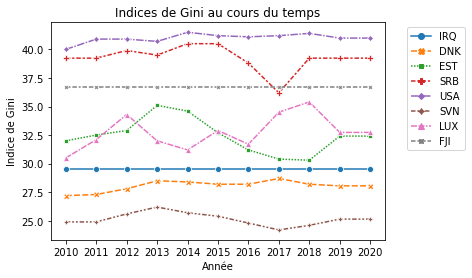

In [88]:

# Evolutions des indices de gini 
gini_T = gini_country.T


_ = sns.lineplot(data=gini_T, markers=True)
_ = plt.title('Indices de Gini au cours du temps')
_ = plt.xlabel('Année')
_ = plt.ylabel('Indice de Gini')
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

_ = plt.show()

### Classez les pays par indice de Gini. Donnez la moyenne, les 5 pays ayant l'indice de Gini le plus élevé et les 5 pays ayant l'indice de Gini le plus faible. En quelle position se trouve la France ?


In [53]:
data

,Country Code,gdpppp,income,quantile,Gini,Country Name,Population,income_log10
0,ALB,7297.0,728.89795,1,0.321410,Albania,2947314.0,2.862667
1,ALB,7297.0,916.66235,2,0.321410,Albania,2947314.0,2.962209
2,ALB,7297.0,1010.91600,3,0.321410,Albania,2947314.0,3.004715
3,ALB,7297.0,1086.90780,4,0.321410,Albania,2947314.0,3.036193
4,ALB,7297.0,1132.69970,5,0.321410,Albania,2947314.0,3.054115
...,...,...,...,...,...,...,...,...
7395,ZAF,9602.0,24553.56800,96,0.682949,South Africa,49779472.0,4.390115
7396,ZAF,9602.0,28858.03100,97,0.682949,South Africa,49779472.0,4.460267
7397,ZAF,9602.0,35750.29000,98,0.682949,South Africa,49779472.0,4.553280
7398,ZAF,9602.0,46297.31600,99,0.682949,South Africa,49779472.0,4.665556


In [54]:
#Les 5 pays avec l'indice de Gini le plus élevé
data_2008_country =  data.groupby(by='Country Code').mean()
data_2008_gini_top = data_2008_country.sort_values(by='Gini', ascending=False)
data_2008_gini_top.head(5)

,gdpppp,income,quantile,Gini,Population,income_log10
Country Code,,,,,,
ZAF,9602.0,5617.904880,50.5,0.682949,49779472.0,3.351777
HND,3628.0,3296.268419,50.5,0.615512,7980955.0,3.205509
COL,8185.0,3547.005276,50.5,0.583437,44254972.0,3.281691
CAF,685.0,811.299901,50.5,0.575972,4273368.0,2.662556
BOL,3950.0,3016.263843,50.5,0.575719,9721457.0,3.195988


In [55]:
# Les 5 pays avec l'indice de Gini le moin élevé
data_2008_gini_down = data_2008_country.sort_values(by='Gini', ascending=True)
data_2008_gini_down.head(5)

,gdpppp,income,quantile,Gini,Population,income_log10
Country Code,,,,,,
SVN,27197.0,12106.007475,50.5,0.248249,2021316.0,4.044249
SVK,20515.0,6096.579894,50.5,0.264573,5379233.0,3.736606
CZE,23223.0,8235.293411,50.5,0.270162,10384603.0,3.867775
SWE,34371.0,16184.222707,50.5,0.272166,9219637.0,4.160020
UKR,6721.0,3349.388306,50.5,0.272415,46258189.0,3.479299


In [56]:
data_mean = data_2008_country.reset_index()
data_mean = data_mean[["income", "Country Code"]]
data_mean = data_mean.rename(columns={"income": "revenu_moyen"})

In [57]:
data = pd.merge(data, data_mean, left_on = 'Country Code', right_on='Country Code')

In [58]:
data

,Country Code,gdpppp,income,quantile,Gini,Country Name,Population,income_log10,revenu_moyen
0,ALB,7297.0,728.89795,1,0.321410,Albania,2947314.0,2.862667,2994.829902
1,ALB,7297.0,916.66235,2,0.321410,Albania,2947314.0,2.962209,2994.829902
2,ALB,7297.0,1010.91600,3,0.321410,Albania,2947314.0,3.004715,2994.829902
3,ALB,7297.0,1086.90780,4,0.321410,Albania,2947314.0,3.036193,2994.829902
4,ALB,7297.0,1132.69970,5,0.321410,Albania,2947314.0,3.054115,2994.829902
...,...,...,...,...,...,...,...,...,...
7395,ZAF,9602.0,24553.56800,96,0.682949,South Africa,49779472.0,4.390115,5617.904880
7396,ZAF,9602.0,28858.03100,97,0.682949,South Africa,49779472.0,4.460267,5617.904880
7397,ZAF,9602.0,35750.29000,98,0.682949,South Africa,49779472.0,4.553280,5617.904880
7398,ZAF,9602.0,46297.31600,99,0.682949,South Africa,49779472.0,4.665556,5617.904880


# MISSION 3 : <a class="anchor" id="mission3"></a>

In [59]:
gdim

,countryname,wbcode,iso3,region,incgroup2,incgroup4,fragile,survey,year,status,...,Cores2125_MAcatC1,Shortfall0611_obs,Shortfall0611_IGP,Shortfall1217_obs,Shortfall1217_IGP,IGEincome,S1,S2,S3,MLD_psu
0,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,25103.0,0.086197,18054.0,0.345224,NaN,NaN,NaN,NaN,0.10
1,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12107.0,0.083271,8538.0,0.389952,NaN,NaN,NaN,NaN,0.10
2,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12996.0,0.089161,9516.0,0.307687,NaN,NaN,NaN,NaN,0.10
3,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,25396.0,0.050447,18387.0,0.218062,NaN,NaN,NaN,NaN,0.10
4,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12246.0,0.047961,8677.0,0.230909,NaN,NaN,NaN,NaN,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6499,Zambia,ZMB,ZMB,Sub-Saharan Africa,Developing economies,Lower middle income,0,LCMS-VI,1980,Co-residents only,...,NaN,1830.0,0.023843,980.0,0.069934,NaN,NaN,NaN,NaN,0.16
6500,Zambia,ZMB,ZMB,Sub-Saharan Africa,Developing economies,Lower middle income,0,LCMS-VI,1980,Co-residents only,...,NaN,1948.0,0.010193,912.0,0.098336,NaN,NaN,NaN,NaN,0.16
6501,Zambia,ZMB,ZMB,Sub-Saharan Africa,Developing economies,Lower middle income,0,LCMS-VI,1980,Co-residents only,...,NaN,4375.0,0.016527,2269.0,0.072795,NaN,NaN,NaN,NaN,0.16
6502,Zambia,ZMB,ZMB,Sub-Saharan Africa,Developing economies,Lower middle income,0,LCMS-VI,1980,Co-residents only,...,NaN,2109.0,0.011469,1183.0,0.088865,NaN,NaN,NaN,NaN,0.16


In [60]:
#Nombre de valeur manquante pour le coéfficient d'élasticité
gdim['IGEincome'].isnull().sum()

5651

In [63]:
#Différents groupe de revenu
gdim['incgroup4'].unique()

array(['Low income', 'Upper middle income', 'Lower middle income',
       'High income'], dtype=object)

In [64]:
#Différentes régions du monde
gdim['region'].unique()

array(['South Asia', 'Sub-Saharan Africa', 'Europe & Central Asia',
       'Latin America & Caribbean', 'High income', 'East Asia & Pacific',
       'Middle East & North Africa'], dtype=object)

In [61]:
gdim_region = gdim.groupby(['region','incgroup4']).mean()
gdim_region 

fragile         year  \
region                     incgroup4                                    
East Asia & Pacific        Lower middle income  0.060453  1964.181360   
                           Upper middle income  0.032258  1967.419355   
Europe & Central Asia      Lower middle income  0.145631  1960.388350   
                           Upper middle income  0.000000  1960.634921   
High income                High income          0.000000  1959.967472   
Latin America & Caribbean  Lower middle income  0.000000  1960.000000   
                           Upper middle income  0.000000  1960.000000   
Middle East & North Africa Lower middle income  0.166667  1963.333333   
                           Upper middle income  0.500000  1963.333333   
South Asia                 Low income           0.166667  1963.333333   
                           Lower middle income  0.000000  1961.285141   
                           Upper middle income  0.000000  1980.000000   
Sub-Saharan Africa         Low income           0.367391  1961.913043   
                           Lower middle income  0.109091  1967.272727   
                           Upper middle income  0.000000  1970.000000   

                                                     cohort          obs  \
region                     incgroup4                                       
East Asia & Pacific        Lower middle income  1964.181360  1011.607053   
                           Upper middle income  1967.419355  2620.669355   
Europe & Central Asia      Lower middle income  1960.388350   280.172330   
                           Upper middle income  1960.634921   300.629630   
High income                High income          1959.967472   844.377209   
Latin America & Caribbean  Lower middle income  1960.000000  1472.836364   
                           Upper middle income  1960.000000  2914.901149   
Middle East & North Africa Lower middle income  1963.333333  2157.671296   
                           Upper middle income  1963.333333  5023.944444   
South Asia                 Low income           1963.333333  1896.916667   
                           Lower middle income  1961.285141  3639.298387   
                           Upper middle income  1980.000000   334.333333   
Sub-Saharan Africa         Low income           1961.913043  1241.697826   
                           Lower middle income  1967.272727  1387.969697   
                           Upper middle income  1970.000000  1102.100000   

                                                      P1        P2        P3  \
region                     incgroup4                                           
East Asia & Pacific        Lower middle income  0.454573  0.248701  0.135176   
                           Upper middle income  0.398496  0.272493  0.160393   
Europe & Central Asia      Lower middle income  0.085857  0.188266  0.205724   
                           Upper middle income  0.088296  0.241096  0.228338   
High income                High income          0.094994  0.236870  0.210608   
Latin America & Caribbean  Lower middle income  0.685335  0.176047  0.042790   
                           Upper middle income  0.497423  0.288627  0.068420   
Middle East & North Africa Lower middle income  0.763957  0.120850  0.047764   
                           Upper middle income  0.622963  0.153622  0.109441   
South Asia                 Low income           0.768693  0.149745  0.030940   
                           Lower middle income  0.652191  0.148074  0.122073   
                           Upper middle income  0.739810  0.041146  0.128355   
Sub-Saharan Africa         Low income           0.818009  0.113975  0.035886   
                           Lower middle income  0.581725  0.172316  0.125893   
                           Upper middle income  0.471669  0.236657  0.141680   

                                                      P4        P5        C1  \
region                     incgroup4                                     

##### On constate qu'il y a une valeur manquante pour l'Asie du sud concernant les "Upper middle income" . J'ai décidé de lui attribuer la valeur de base pour l'asie du sud qui est dans le fichier "elasticity.txt".

In [66]:
gdim_region = gdim.groupby(['region','incgroup4']).mean()

In [62]:
#Remplace les valeurs nulles par la valeur 0.5
gdim_region.loc[gdim_region['IGEincome'].isnull(),'IGEincome']=0.5


gdim_region = gdim_region[['IGEincome']]
gdim_region

IGEincome
region                     incgroup4                     
East Asia & Pacific        Lower middle income   0.527665
                           Upper middle income   0.469500
Europe & Central Asia      Lower middle income   0.424817
                           Upper middle income   0.477171
High income                High income           0.348050
Latin America & Caribbean  Lower middle income   0.940737
                           Upper middle income   0.878852
Middle East & North Africa Lower middle income   0.916461
                           Upper middle income   0.517398
South Asia                 Low income            0.436000
                           Lower middle income   0.523840
                           Upper middle income   0.500000
Sub-Saharan Africa         Low income            0.661654
                           Lower middle income   0.629976
                           Upper middle income   0.677000

In [63]:
gdim_region =gdim_region.reset_index()
gdim = gdim.merge(gdim_region, left_on=['region','incgroup4'],
                            right_on=['region','incgroup4'], suffixes=('_norm', '_mean')  )
gdim


,countryname,wbcode,iso3,region,incgroup2,incgroup4,fragile,survey,year,status,...,Shortfall0611_obs,Shortfall0611_IGP,Shortfall1217_obs,Shortfall1217_IGP,IGEincome_norm,S1,S2,S3,MLD_psu,IGEincome_mean
0,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,25103.0,0.086197,18054.0,0.345224,NaN,NaN,NaN,NaN,0.1,0.436
1,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,12107.0,0.083271,8538.0,0.389952,NaN,NaN,NaN,NaN,0.1,0.436
2,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,12996.0,0.089161,9516.0,0.307687,NaN,NaN,NaN,NaN,0.1,0.436
3,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,25396.0,0.050447,18387.0,0.218062,NaN,NaN,NaN,NaN,0.1,0.436
4,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,12246.0,0.047961,8677.0,0.230909,NaN,NaN,NaN,NaN,0.1,0.436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6499,Maldives,MDV,MDV,South Asia,Developing economies,Upper middle income,0,HIES,1980,Co-residents only,...,304.0,0.004317,441.0,0.000221,NaN,NaN,NaN,NaN,NaN,0.500
6500,Maldives,MDV,MDV,South Asia,Developing economies,Upper middle income,0,HIES,1980,Co-residents only,...,350.0,-0.008552,483.0,0.041431,NaN,NaN,NaN,NaN,NaN,0.500
6501,Maldives,MDV,MDV,South Asia,Developing economies,Upper middle income,0,HIES,1980,Co-residents only,...,846.0,0.004874,1204.0,0.028466,NaN,NaN,NaN,NaN,NaN,0.500
6502,Maldives,MDV,MDV,South Asia,Developing economies,Upper middle income,0,HIES,1980,Co-residents only,...,402.0,0.003696,584.0,0.005969,NaN,NaN,NaN,NaN,NaN,0.500


In [64]:
#remplacement des valeurs nulles par les valeurs moyennes 
gdim_data = gdim[[ 'iso3', 'IGEincome_norm', 'IGEincome_mean'  ]]
gdim_data.groupby('iso3').mean()
gdim_data.loc[gdim_data['IGEincome_norm'].isnull(),'IGEincome_norm'] = gdim_data.loc[gdim_data['IGEincome_norm'].isnull(),'IGEincome_mean']


/Users/emmanuelmoudoute-bell/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [65]:
gdim_data=gdim_data.groupby('iso3').mean().reset_index()

In [66]:
gdim_data

,iso3,IGEincome_norm,IGEincome_mean
0,AFG,0.436000,0.436000
1,AGO,0.677000,0.677000
2,ALB,0.544912,0.477171
3,ARG,0.878852,0.878852
4,ARM,0.424817,0.424817
...,...,...,...
145,VNM,0.516873,0.527665
146,VUT,0.527665,0.527665
147,YEM,0.916461,0.916461
148,ZAF,0.677000,0.677000


In [67]:
gdim_data = gdim_data.rename(columns={'iso3': 'Country Code'})
main_df = data.merge(gdim_data,how='left', 
                         on=['Country Code'], 
                         )
main_df = main_df[['Country Code','quantile',
                            'gdpppp','income','revenu_moyen','Gini','IGEincome_norm', 'income_log10']]
main_df

,Country Code,quantile,gdpppp,income,revenu_moyen,Gini,IGEincome_norm,income_log10
0,ALB,1,7297.0,728.89795,2994.829902,0.321410,0.544912,2.862667
1,ALB,2,7297.0,916.66235,2994.829902,0.321410,0.544912,2.962209
2,ALB,3,7297.0,1010.91600,2994.829902,0.321410,0.544912,3.004715
3,ALB,4,7297.0,1086.90780,2994.829902,0.321410,0.544912,3.036193
4,ALB,5,7297.0,1132.69970,2994.829902,0.321410,0.544912,3.054115
...,...,...,...,...,...,...,...,...
7395,ZAF,96,9602.0,24553.56800,5617.904880,0.682949,0.677000,4.390115
7396,ZAF,97,9602.0,28858.03100,5617.904880,0.682949,0.677000,4.460267
7397,ZAF,98,9602.0,35750.29000,5617.904880,0.682949,0.677000,4.553280
7398,ZAF,99,9602.0,46297.31600,5617.904880,0.682949,0.677000,4.665556


In [68]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7400 entries, 0 to 7399
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Code    7400 non-null   object 
 1   quantile        7400 non-null   int64  
 2   gdpppp          7400 non-null   float64
 3   income          7400 non-null   float64
 4   revenu_moyen    7400 non-null   float64
 5   Gini            7400 non-null   float64
 6   IGEincome_norm  7400 non-null   float64
 7   income_log10    7400 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 520.3+ KB


In [69]:
main_df.loc[main_df['IGEincome_norm'].isnull(),:]

,Country Code,quantile,gdpppp,income,revenu_moyen,Gini,IGEincome_norm,income_log10


In [70]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7400 entries, 0 to 7399
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Code    7400 non-null   object 
 1   quantile        7400 non-null   int64  
 2   gdpppp          7400 non-null   float64
 3   income          7400 non-null   float64
 4   revenu_moyen    7400 non-null   float64
 5   Gini            7400 non-null   float64
 6   IGEincome_norm  7400 non-null   float64
 7   income_log10    7400 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 520.3+ KB


### Question 1 à 6 :

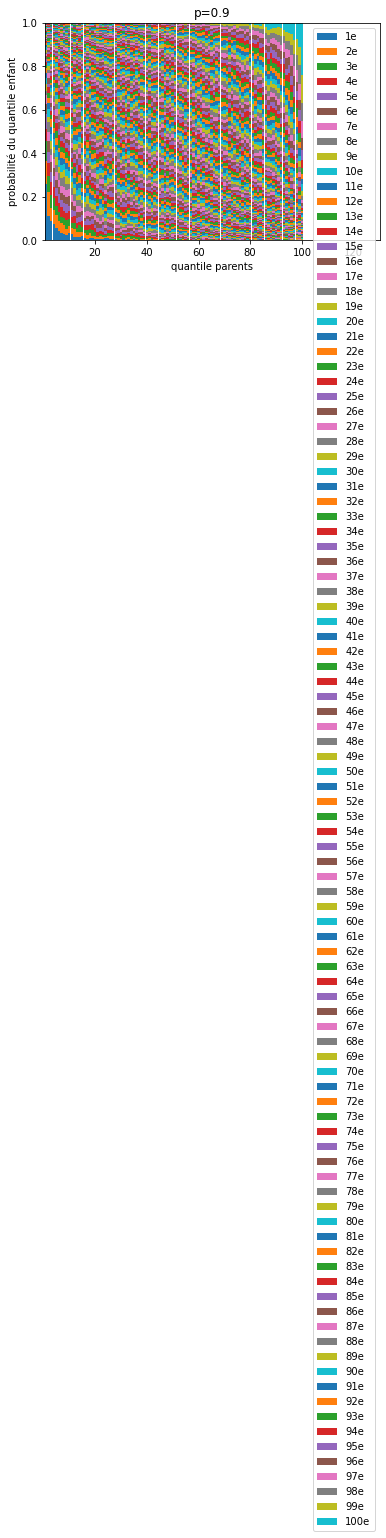

[[0.258 0.11  0.087 ... 0.    0.    0.   ]
 [0.107 0.11  0.062 ... 0.    0.    0.   ]
 [0.091 0.077 0.06  ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.068 0.086 0.082]
 [0.    0.    0.    ... 0.072 0.083 0.127]
 [0.    0.    0.    ... 0.075 0.113 0.242]]

P(c_i_parent = 8 | c_i_child = 5, pj = 0.9) = 0.035


In [71]:
pj = 0.9                 # coefficient d'élasticité du pays j
nb_quantiles = 100       # nombre de quantiles (nombre de classes de revenu)
n  = 1000*nb_quantiles   # taille de l'échantillon

y_child, y_parents = generate_incomes(n, pj)
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd = conditional_distributions(sample, nb_quantiles)
plot_conditional_distributions(pj, cd, nb_quantiles) # Cette instruction prendra du temps si nb_quantiles > 10
print(cd)

c_i_child = 5 
c_i_parent = 8
p = proba_cond(c_i_parent, c_i_child, cd)
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child, pj, p))

In [73]:
#Augmentation de la taille de l'échantillon 
main_df_study = pd.concat([main_df] * 500, ignore_index=True)

In [74]:
main_df_study.shape

(3700000, 8)

In [75]:
main_df_study.rename(columns={'quantile': 'c_i_child', 'income': 'y_child', 'Gini': 'Gj', 'IGEincome_norm': 'pj', 'revenu_moyen': 'mj'}, inplace=True)
main_df_study = main_df_study[['Country Code', 'c_i_child', 'y_child', 'Gj', 'pj', 'mj','income_log10']]
main_df_study.shape

(3700000, 7)

In [76]:
main_df_study = main_df_study.sort_values(by=['Country Code','c_i_child']).reset_index()

In [77]:
#Application du protocole à notre jeu de données
pays_list=main_df_study['Country Code'].unique()
classe_parent=0
classe_enfant=0
list_prob=[]

for pays in pays_list:
    pj=main_df_study.loc[main_df_study['Country Code']==pays,'pj'].iloc[0]
    nb_quantiles = 100 # nombre de quantiles (nombre de classes de revenu)
    n = 500 * nb_quantiles # taille de l'échantillon
    y_child, y_parents = generate_incomes(n, pj) # Calcule des revenus enfants et parents 
    sample = compute_quantiles(y_child, y_parents, nb_quantiles)
    cd = conditional_distributions(sample, nb_quantiles)
    for c_i_child in range(100):
        for c_i_parent in range(100):
            p = proba_cond(c_i_parent, c_i_child, cd) # Probabilité conditionelle 
            list_prob.extend([c_i_parent+1]*(int(p*500))) # distribution de cette probailité conditionelle

In [78]:
len(list_prob)

3700000

In [79]:
main_df_study['classe_parent']=list_prob
main_df_study.groupby(['Country Code','c_i_child','classe_parent']).count()

index  y_child  Gj  pj  mj  income_log10
Country Code c_i_child classe_parent                                          
ALB          1         1                 64       64  64  64  64            64
                       2                 33       33  33  33  33            33
                       3                 34       34  34  34  34            34
                       4                 32       32  32  32  32            32
                       5                 19       19  19  19  19            19
...                                     ...      ...  ..  ..  ..           ...
ZAF          100       96                22       22  22  22  22            22
                       97                32       32  32  32  32            32
                       98                43       43  43  43  43            43
                       99                48       48  48  48  48            48
                       100               75       75  75  75  75            75

[701066 rows x 6 columns]

In [80]:
main_df_study

,index,Country Code,c_i_child,y_child,Gj,pj,mj,income_log10,classe_parent
0,0,ALB,1,728.89795,0.321410,0.544912,2994.829902,2.862667,1
1,7400,ALB,1,728.89795,0.321410,0.544912,2994.829902,2.862667,1
2,14800,ALB,1,728.89795,0.321410,0.544912,2994.829902,2.862667,1
3,22200,ALB,1,728.89795,0.321410,0.544912,2994.829902,2.862667,1
4,29600,ALB,1,728.89795,0.321410,0.544912,2994.829902,2.862667,1
...,...,...,...,...,...,...,...,...,...
3699995,3670399,ZAF,100,82408.55000,0.682949,0.677000,5617.904880,4.915972,100
3699996,3677799,ZAF,100,82408.55000,0.682949,0.677000,5617.904880,4.915972,100
3699997,3685199,ZAF,100,82408.55000,0.682949,0.677000,5617.904880,4.915972,100
3699998,3692599,ZAF,100,82408.55000,0.682949,0.677000,5617.904880,4.915972,100


## Mission 4:

### Anova

In [89]:
plot_anova = main_df_study.set_index('Country Code')

plot_anova =plot_anova.loc(axis=0)[ 'IRQ','DNK', 'EST', 'SRB', 'USA','SVN' , 'LUX', 'FJI'].reset_index()


In [90]:
plot_anova

,Country Code,index,c_i_child,y_child,Gj,pj,mj,income_log10,classe_parent
0,IRQ,3500,1,185.81454,0.376320,0.517398,1705.512343,2.269080,1
1,IRQ,10900,1,185.81454,0.376320,0.517398,1705.512343,2.269080,1
2,IRQ,18300,1,185.81454,0.376320,0.517398,1705.512343,2.269080,1
3,IRQ,25700,1,185.81454,0.376320,0.517398,1705.512343,2.269080,1
4,IRQ,33100,1,185.81454,0.376320,0.517398,1705.512343,2.269080,1
...,...,...,...,...,...,...,...,...,...
399995,FJI,3665599,100,22161.59000,0.443783,0.469500,2098.730882,4.345601,100
399996,FJI,3672999,100,22161.59000,0.443783,0.469500,2098.730882,4.345601,100
399997,FJI,3680399,100,22161.59000,0.443783,0.469500,2098.730882,4.345601,100
399998,FJI,3687799,100,22161.59000,0.443783,0.469500,2098.730882,4.345601,100


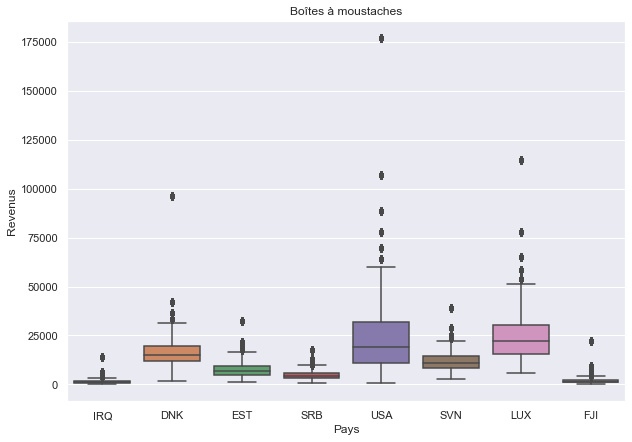

In [91]:
sns.set()
plt.figure(figsize=(10,7))
ax = sns.boxplot(x="Country Code", y="y_child", data=plot_anova)
plt.xlabel('Pays')
plt.ylabel('Revenus')
plt.title('Boîtes à moustaches')
plt.show()

ce graphique nous montre que selon le pays la moyenne des revenues est différentes il semblerait que le pays joue un rôle dans les revenus.

In [92]:
main_df_study.rename(columns={'Country Code': 'Country_Code'}, inplace=True)
main_df_study.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3700000 entries, 0 to 3699999
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   index          int64  
 1   Country_Code   object 
 2   c_i_child      int64  
 3   y_child        float64
 4   Gj             float64
 5   pj             float64
 6   mj             float64
 7   income_log10   float64
 8   classe_parent  int64  
dtypes: float64(5), int64(3), object(1)
memory usage: 254.1+ MB


In [93]:
fit_data = smf.ols('y_child~Country_Code', data=main_df_study).fit()
print(fit_data.summary())

                            OLS Regression Results                            
Dep. Variable:                y_child   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                 4.064e+04
Date:                Sat, 30 Oct 2021   Prob (F-statistic):               0.00
Time:                        00:47:10   Log-Likelihood:            -3.8494e+07
No. Observations:             3700000   AIC:                         7.699e+07
Df Residuals:                 3699926   BIC:                         7.699e+07
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            2994.8299    

Ce qui nous intéresse réellement, c'est le test de Fisher. La p-valeur de ce test ( 0) est très petite et largement inférieure à 5 %. On rejette donc l'hypothèse H0 selon laquelle  α1=α2=α3=α4=0 .

Le pays  a donc bien un effet sur les revenues des habitants , comme nous en avions l'intuition en regardant les boîtes à moustaches.

Pour obtenir le tableau de l'analyse de la variance, on utilise la commande anova_lm :

In [117]:
sm.stats.anova_lm(fit_data, typ=2)

,sum_sq,df,F,PR(>F)
Country_Code,1.890249e+14,73.0,40641.221048,0.0
Residual,2.357341e+14,3699926.0,NaN,NaN


### Régréssion linéaire :

#### Appliquez une régression linéaire sur vos données, en incluant comme variables explicatives uniquement le revenu moyen du pays de l’individu et l’indice de Gini du pays de l’individu.

In [94]:
regression_data = smf.ols('y_child~mj+Gj', data=main_df_study).fit()
print(regression_data.summary())

                            OLS Regression Results                            
Dep. Variable:                y_child   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                 1.483e+06
Date:                Sat, 30 Oct 2021   Prob (F-statistic):               0.00
Time:                        00:51:04   Log-Likelihood:            -3.8494e+07
No. Observations:             3700000   AIC:                         7.699e+07
Df Residuals:                 3699997   BIC:                         7.699e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.215e-10     20.852   1.06e-11      1.0

#### Quel est le pourcentage de variance expliquée par votre modèle ?

Le pourcentage de variance expliqué par notre modèle est de 44,5 % 

La décomposition de la variance totale 


##### Régression en version Log :

In [95]:
main_df_study['mj_log'] = main_df_study['mj'].apply(lambda x: math.log10(x))

In [96]:
regression_data_1_log = smf.ols('income_log10~mj_log+Gj', data=main_df_study).fit()
print(regression_data_1_log.summary())

                            OLS Regression Results                            
Dep. Variable:           income_log10   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                 4.228e+06
Date:                Sat, 30 Oct 2021   Prob (F-statistic):               0.00
Time:                        00:59:44   Log-Likelihood:            -9.4981e+05
No. Observations:             3700000   AIC:                         1.900e+06
Df Residuals:                 3699997   BIC:                         1.900e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2128      0.002    116.393      0.0

Le pourcentage de variance expliqué par notre modèle est de 69,6 %

#### Améliorez le modèle précédent en incluant maintenant la classe de revenu des parents. Quel est le pourcentage de variance expliquée par ce nouveau modèle ?

In [100]:
regression_data_2 = smf.ols('y_child~mj+Gj+classe_parent', data=main_df_study).fit()
print(regression_data_2.summary())

                            OLS Regression Results                            
Dep. Variable:                y_child   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                 1.131e+06
Date:                Sat, 30 Oct 2021   Prob (F-statistic):               0.00
Time:                        01:17:50   Log-Likelihood:            -3.8380e+07
No. Observations:             3700000   AIC:                         7.676e+07
Df Residuals:                 3699996   BIC:                         7.676e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3422.4719     21.406   -159.881

##### Le pourcentage de variance expliqué par notre modèle est de 47,8 %
##### On constate aussi que le coefficient affecté à l'indice de Gini est négatif et très petit comparé aux autres coefficients ce qui veut dire que son impacte est faible . Donc on peut supposer que vivre dans un pays inégalitaire favorise plus de personnes qu'il n'en défavorise

In [101]:
regression_data_1_log = smf.ols('income_log10~mj_log+Gj+classe_parent', data=main_df_study).fit()
print(regression_data_1_log.summary())

                            OLS Regression Results                            
Dep. Variable:           income_log10   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                 3.717e+06
Date:                Sat, 30 Oct 2021   Prob (F-statistic):               0.00
Time:                        01:24:57   Log-Likelihood:            -5.7914e+05
No. Observations:             3700000   AIC:                         1.158e+06
Df Residuals:                 3699996   BIC:                         1.158e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0203      0.002    -12.150

##### Le pourcentage de variance expliqué par notre modèle est de 75,1 %